In [1]:
import pickle
import numpy as np
import pandas as pd
import statistics
import matplotlib.pyplot as plt


In [2]:
# Author Andy Webber andygwebber@yahoo.com

# Parameters Author believes users will be most likely to play with

# The script works with indicies, wavenumbers can be calculated from indicies by multiplying by 2 pi/L
# Windows refer to normalized energy exchanges between larger and smaller indicies
# The index in question, will range from _start to _stop. For 
# each of these indicies an energy exchange is calculated and normalized by the dissipation
# of that index. The window_size sets the highest and lowest indicies considered.
# For example, _start = 30, _stop = 55, and _window_size = 35 will produce 26 (30 to 55 inclusive)
# profiles each of size 35 ranging from 17 indicies below the wavenumber to 17 above. The scripts
# will calculate and plot the mean of these normalized profiles and include shaded area two standard
# deviations above and below the mean. 

spanwise_start = 30 # Where to start windowing, about where mother input drops off
spanwise_stop = 58  # Stop windowing a little bit before N3S
spanwise_window_size = 35  # The range of modes used for convection profile, must be odd. 

streamwise_start = 20 # Where to start windowing, about where mother input drops off
streamwise_stop = 47  # Stop windowing a little bit before N3S
streamwise_window_size = 31  # The range of modes used for convection profile, must be odd. 


# Parameters of the paper that should not be changed
N1S = 48 # Number of streamwise wavenumbers in tracking subspace
N3S = 59 # Number of spanwise wavenumbers in tracking subspace
X1L = 12.56637 # Streamwise length of the channel
X3L = 6.28319 # Spanwise widgth of the channel
pi = 3.14159

In [3]:
OUT_OF_BOUNDS = 100.0  # Value to set when accessing info beyond array

def calculate_profile(row, npp, NS, dissipation):
    ''' This calculates single profile using row, npp and viscous_loss '''
    
    profile = np.zeros(len(npp))
    
    for i in range(len(npp)):
        npp_i = npp[i]
        if npp_i < NS:
            profile[i] = row[npp_i]/dissipation
        else:
            profile[i] = OUT_OF_BOUNDS
            
    return(profile)

def convection_profile(
    n_low, n_high, window_size, NS, XL, transfer_matrix, account):
    convection_profiles = np.zeros((window_size, (n_high - n_low)+1))

    """ Calculate a normalized convection transfer profile for each wavenumber from n_low to n_high
        This is the amount of energy recieved from lower wavenumbers and energy sent to higher wavenumbers.
        Each profile width is set by the parameter window_size so if window_size is 35, each profile will
        have 35 values ranging from 17 indicies below to 17 indicies above. In some cases, the profile will
        be truncated because it is trying to access exchange with wavenumbers beyond subspace used in this work"""
    
    npp = [i for i in range(window_size)] # This just initializes space
    reach = round((window_size - 1) / 2) # number to go above and below n
    
    convection_profile = np.zeros(window_size)
    
    for n in range(n_low, n_high+1):
        # n fixed so calculate npp
        for n_minus_npp in range(-reach, reach+1):
            index = n_minus_npp  + reach
            npp[index] = n - n_minus_npp
        row = transfer_matrix[n][:]
        dissipation = account["Dissipation"][n]
        convection_profile = calculate_profile(
            row, npp, NS, dissipation)
        icount = n - n_low # convection_profiles starts indexing at 0
        convection_profiles[:, icount] = convection_profile    
        
    k_min_kpp = np.zeros(window_size) # n_min_npp is n - npp
    for i in range(window_size):
        k_min_kpp[i] = (float(i) - float(reach)) * 2.0 * pi/XL
    
    mean = np.zeros(window_size)
    std = np.zeros(window_size) 
    for in_min_npp in range(window_size):
        row = convection_profiles[in_min_npp,:]
        row_screened = row[row<OUT_OF_BOUNDS/2]
        mean[in_min_npp] = statistics.mean(row_screened)
        std[in_min_npp] = statistics.stdev(row_screened)       
        
    return (k_min_kpp, mean, std)

In [4]:
# Read in the spanwise data to be used
df_spanwise = pd.read_csv("spanwise_budget.txt", sep=' ')

spanwise_transfer = pickle.load(open("spanwise_transfer.bin", "rb"))
df_spanwise

Pressure_input  Production  Transfer_in  Transfer_out  Dissipation  \
0        15.670533    0.000000     0.032103      6.293166     9.422606   
1         0.000003   -0.024209     0.139475      0.001874     0.108938   
2         0.000000   -0.007856     0.249874      0.006921     0.225069   
3         0.000000    0.097060     0.180043      0.025647     0.241211   
4         0.000000    0.202604     0.118400      0.057680     0.253632   
5         0.000000    0.303027     0.066874      0.091296     0.268650   
6         0.000000    0.399035     0.025420      0.129524     0.284813   
7         0.000000    0.469068     0.004128      0.166070     0.296928   
8         0.000000    0.477884     0.001610      0.176712     0.293374   
9         0.000000    0.505965     0.001032      0.200682     0.296624   
10        0.000000    0.478469     0.000487      0.182776     0.286616   
11        0.000000    0.445667     0.003501      0.169557     0.269641   
12        0.000000    0.390660     0.020082      0.152208     0.248798   
13        0.000000    0.365818     0.031606      0.151507     0.236257   
14        0.000000    0.314612     0.048445      0.137568     0.215734   
15        0.000000    0.282536     0.060398      0.133255     0.200178   
16        0.000000    0.242773     0.073281      0.123921     0.183084   
17        0.000000    0.203317     0.083423      0.112508     0.165206   
18        0.000000    0.174536     0.091258      0.105775     0.151448   
19        0.000000    0.148145     0.097915      0.099726     0.138065   
20        0.000000    0.126600     0.102085      0.093696     0.126742   
21        0.000000    0.105874     0.104385      0.087080     0.115392   
22        0.000000    0.089955     0.103870      0.080833     0.105472   
23        0.000000    0.075315     0.103320      0.074878     0.096395   
24        0.000000    0.063630     0.101656      0.069948     0.088461   
25        0.000000    0.054238     0.099081      0.065156     0.081456   
26        0.000000    0.045290     0.095202      0.059654     0.074553   
27        0.000000    0.038273     0.090974      0.054948     0.068278   
28        0.000000    0.031729     0.087457      0.050611     0.062737   
29        0.000000    0.026873     0.083032      0.046696     0.057696   
30        0.000000    0.022642     0.079116      0.043254     0.053237   
31        0.000000    0.018884     0.074913      0.039853     0.048923   
32        0.000000    0.015583     0.070881      0.036539     0.045080   
33        0.000000    0.013195     0.066791      0.033607     0.041701   
34        0.000000    0.011188     0.062686      0.030856     0.038494   
35        0.000000    0.009213     0.058797      0.028194     0.035460   
36        0.000000    0.007854     0.055199      0.025947     0.032860   
37        0.000000    0.006509     0.051817      0.023811     0.030394   
38        0.000000    0.005293     0.048363      0.021623     0.027998   
39        0.000000    0.004549     0.045159      0.019786     0.025999   
40        0.000000    0.003686     0.042225      0.017971     0.024048   
41        0.000000    0.003110     0.039406      0.016335     0.022304   
42        0.000000    0.002509     0.036590      0.014690     0.020561   
43        0.000000    0.002097     0.034107      0.013278     0.019049   
44        0.000000    0.001671     0.031960      0.011966     0.017733   
45        0.000000    0.001369     0.029609      0.010600     0.016388   
46        0.000000    0.001135     0.027575      0.009382     0.015215   
47        0.000000    0.000927     0.025662      0.008277     0.014128   
48        0.000000    0.000719     0.023877      0.007158     0.013096   
49        0.000000    0.000596     0.022237      0.006144     0.012191   
50        0.000000    0.000430     0.020678      0.005095     0.011319   
51        0.000000    0.000354     0.019180      0.004163     0.010496   
52        0.000000    0.000258     0.017809      0.003227     0.009771   
53      

In [14]:
balance_sum = (df_spanwise[["Balance"]].to_numpy()).sum()
print('The sum of the balance terms is %.4f' % balance_sum)

The sum of the balance terms is 0.3682


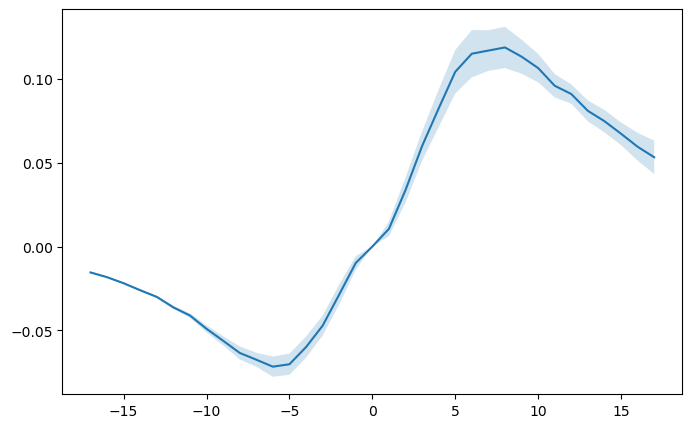

In [5]:
# Calculate and plot the spanwise convection profiles

k3_min_k3pp, spanwise_profile_mean, spanwise_profile_std = convection_profile(
    spanwise_start,
    spanwise_stop,
    spanwise_window_size,
    N3S,
    X3L,
    spanwise_transfer,
    df_spanwise,
)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))

plt.plot(k3_min_k3pp, spanwise_profile_mean)
plt.fill_between(k3_min_k3pp, spanwise_profile_mean-2*spanwise_profile_std, 
                              spanwise_profile_mean+2*spanwise_profile_std, alpha=0.2, label='error band')

In [6]:
# Read in the streamwise data to be used
df_streamwise = pd.read_csv("streamwise_budget.txt", sep=' ')

streamwise_transfer = pickle.load(open("streamwise_transfer.bin", "rb"))
df_streamwise

Pressure_input  Mother_input  Transfer_in  Transfer_out  Dissipation  \
0        15.670533      0.000000     0.011980      6.273045     9.422606   
1         0.000003      0.956211     0.000000      0.576229     0.377813   
2         0.000000      1.454596     0.064312      0.867108     0.644896   
3         0.000000      0.972588     0.173465      0.624746     0.514603   
4         0.000000      0.705940     0.237516      0.494050     0.442615   
5         0.000000      0.522713     0.274532      0.405691     0.384795   
6         0.000000      0.392646     0.292327      0.340000     0.337978   
7         0.000000      0.293347     0.297662      0.285477     0.298503   
8         0.000000      0.228359     0.292017      0.246427     0.266957   
9         0.000000      0.172865     0.288046      0.215682     0.238436   
10        0.000000      0.131409     0.275755      0.187676     0.212840   
11        0.000000      0.101576     0.265951      0.168592     0.192154   
12        0.000000      0.078762     0.253416      0.152141     0.173541   
13        0.000000      0.060586     0.239588      0.136777     0.157014   
14        0.000000      0.047297     0.225201      0.124253     0.141883   
15        0.000000      0.036603     0.212422      0.113362     0.129303   
16        0.000000      0.028701     0.198335      0.103727     0.117205   
17        0.000000      0.022398     0.186525      0.095648     0.107040   
18        0.000000      0.017067     0.174392      0.087692     0.097680   
19        0.000000      0.013359     0.163409      0.081428     0.089197   
20        0.000000      0.010184     0.152645      0.074989     0.081685   
21        0.000000      0.007695     0.142883      0.069483     0.074817   
22        0.000000      0.005865     0.133633      0.064620     0.068673   
23        0.000000      0.004265     0.125174      0.060045     0.063122   
24        0.000000      0.003033     0.116730      0.055332     0.058031   
25        0.000000      0.002151     0.108958      0.051227     0.053416   
26        0.000000      0.001491     0.101898      0.047521     0.049270   
27        0.000000      0.000866     0.094968      0.043626     0.045423   
28        0.000000      0.000399     0.088949      0.040465     0.041960   
29        0.000000      0.000074     0.083229      0.037320     0.038811   
30        0.000000     -0.000202     0.077802      0.034251     0.035896   
31        0.000000     -0.000404     0.072565      0.031386     0.033212   
32        0.000000     -0.000525     0.067971      0.028870     0.030803   
33        0.000000     -0.000627     0.063433      0.026236     0.028534   
34        0.000000     -0.000692     0.059529      0.023900     0.026497   
35        0.000000     -0.000738     0.055521      0.021514     0.024583   
36        0.000000     -0.000760     0.052058      0.019381     0.022858   
37        0.000000     -0.000765     0.048634      0.017219     0.021226   
38        0.000000     -0.000765     0.045470      0.015218     0.019744   
39        0.000000     -0.000760     0.042620      0.013347     0.018382   
40        0.000000     -0.000739     0.039854      0.011477     0.017103   
41        0.000000     -0.000715     0.037341      0.009696     0.015938   
42        0.000000     -0.000699     0.034928      0.007945     0.014851   
43        0.000000     -0.000676     0.032669      0.006290     0.013848   
44        0.000000     -0.000646     0.030666      0.004807     0.012931   
45        0.000000     -0.000610     0.028701      0.003355     0.012074   
46        0.000000     -0.000584     0.026906      0.002077     0.011267   
47        0.000000     -0.000554     0.025156      0.001041     0.010514   
48        0.000000     -0.000519     0.023578      0.000000     0.009824   

     Balance  
0  -0.013138  
1   0.002173  
2   0.006905  
3   0.006704  
4   0.006791  
5   0.006759  
6   0.006995  
7   0.007029  
8   0.006991  
9   0.006792  
10  0.006648  
11  0.006781  
12  0.00

In [15]:
balance_sum = (df_streamwise[["Balance"]].to_numpy()).sum()
print('The sum of the balance terms is %.4f' % balance_sum)

The sum of the balance terms is 0.3682


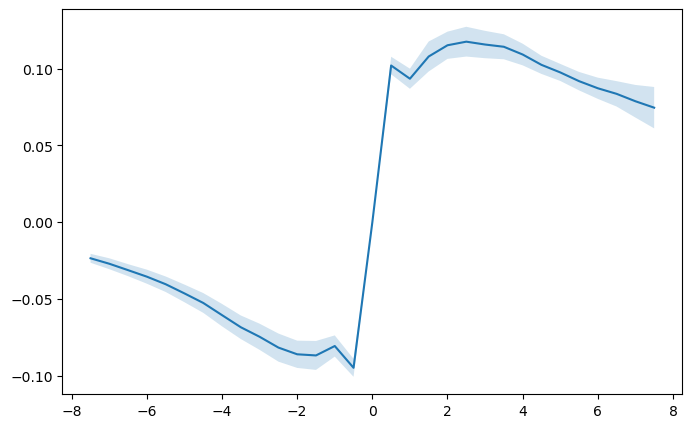

In [7]:
# Calculate and plot the spanwise convection profiles

k1_min_k1pp, streamwise_profile_mean, streamwise_profile_std = convection_profile(
    streamwise_start,
    streamwise_stop,
    streamwise_window_size,
    N1S,
    X1L,
    streamwise_transfer,
    df_streamwise,
)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))

plt.plot(k1_min_k1pp, streamwise_profile_mean)
plt.fill_between(k1_min_k1pp, streamwise_profile_mean-2*streamwise_profile_std, 
                              streamwise_profile_mean+2*streamwise_profile_std, alpha=0.2, label='error band')